In [2]:
# Required Packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Generator
Our input data will consist of random images of shape $(100, 100, 3)$ and random string text encoded in ASCII, we will provide some example of the input data below.

In [3]:
# Parameters
max_len = 128
shape = (256, 256, 3)
dict_len = 255 # ASCII CODE

# NN Parameters
batch_size = 32

def get_image():
  """
  Generate a random image.

  Returns:
    numpy.ndarray: A random image represented as a NumPy array.
  """
  return np.random.rand(shape[0], shape[1], shape[2])

def ascii_encode(text):
  """
  Encodes the given text into ASCII values.

  Parameters:
  text (str): The text to be encoded.

  Returns:
  numpy.ndarray: A 2D numpy array containing the ASCII values of the characters in the text.
  """

  encode = np.full((1,max_len), 32, dtype=float)
  for i in range(len(text)):
    encode[0][i] = ord(text[i])
  return encode

def get_text():
  """
  Generates a random sequence of integers representing text.

  Returns:
    numpy.ndarray: A random sequence of integers.
  """
  return np.random.randint(0, dict_len+1, max_len)

# The output of the network will be in one_hot_encoding
def one_hot(text):
  """
  Converts a given text into a one-hot encoded representation.

  Parameters:
  text (str): The input text to be encoded.

  Returns:
  numpy.ndarray: A numpy array representing the one-hot encoded text.
  """
  onehot = np.zeros((len(text), dict_len))
  for i in range(len(onehot)):
    onehot[i][text[i]-1] = 1.
  return onehot

def decode_text(text):
  """
  Decodes the given text using the ASCII values.

  Parameters:
  text (numpy.ndarray): The input text to be decoded.

  Returns:
  str: The decoded text.

  """
  ascii_array = np.zeros(max_len, dtype=int)
  for i in range(max_len):
    ascii_array[i] = np.argmax(text[i], axis=-1)+1
  print(ascii_array)
  return ''.join([chr(code) for code in ascii_array])

## Example of input data

In [4]:
# Random text
tmp = get_text()
print("Ascii: ", tmp)
print("String: ", ''.join([chr(code) for code in tmp]))

Ascii:  [ 35 218 209  80  66  96  35 230 153 235 157 179 211 110 250  20  29 241
 171 106 134 239 217 237 248  74 203 227 130 162  98 244  39  11  16  73
 164 175  17 116 213 238 104 227 118 222  11  96   9 161 131 183  38 182
 152  40  84   8  14 201 241 138   6 109 127 110  34 163  89  59 105 211
 177 161 229  31 227 192  86  10 248   5 144 171 116  78 137 125 179  72
  88 132 112 169 105  39  86 206 180 104 211  21 107  84   8 148 115 250
  30  33  84 148  57 148  52 170 168 195 209  28 117 182 144  70  12  86
   1 230]
String:  #ÚÑPB`#æë³Ónúñ«jïÙíøJËã¢bô'I¤¯tÕîhãvÞ`	¡·&¶(Éñmn"£Y;iÓ±¡åãÀV
ø«tN}³HXp©i'VÎ´hÓksú!T94ª¨ÃÑu¶FVæ


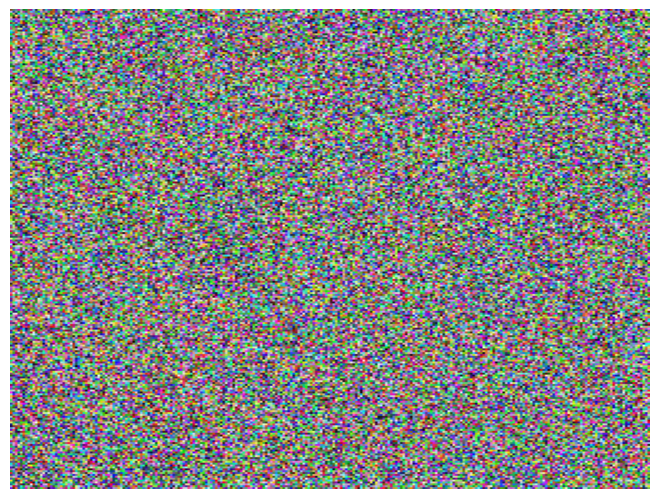

In [12]:
fig = plt.figure(frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(get_image(), aspect='auto')
fig.savefig("example_input.png")

AttributeError: AxesImage.set() got an unexpected keyword argument 'axis'

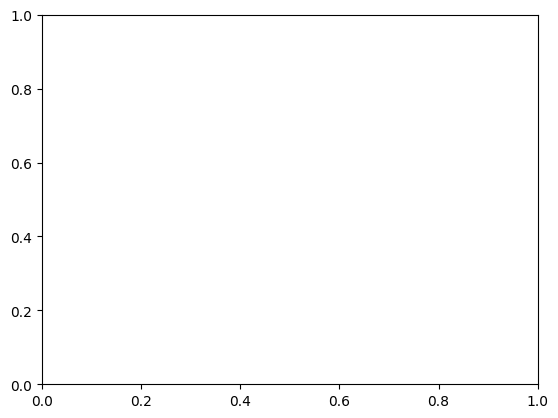

In [9]:
plt.imshow(get_image(), axis='off')
plt.savefig('example_input.png')


## Code for the generator
With the auxiliary functions defined on top, we will create a python generator, that will return **(img, text)** for the input of the NN and **(img, one_hot_text)** for the desired prediction with the NN.

In [5]:
def generator():
  while True:
    imgs = np.zeros((batch_size, shape[0],shape[1], shape[2]))
    texts = np.zeros((batch_size, max_len))
    one_hot_texts = np.zeros((batch_size, max_len, dict_len))
    for i in range(batch_size):
      imgs[i] = get_image()
      text = get_text()
      texts[i] = text
      one_hot_texts[i] = one_hot(text)
    yield ([imgs, texts], [imgs, one_hot_texts])

In [7]:
# Example of generator
tmp = generator()
# Each time we call tmp we will get a new batch of data
next(tmp)[0][1]

array([[ 22.,  16.,  90., ...,  86., 189., 168.],
       [224.,  38.,  11., ...,  15.,  10., 246.],
       [137.,  81.,  32., ...,  76., 235.,   9.],
       ...,
       [195.,  72., 130., ...,  41.,  89., 125.],
       [ 83.,  51.,  37., ...,  73.,  42.,  66.],
       [244., 209.,  17., ..., 145.,  40., 151.]])

# Network Arquitecture
We will build the model and display the arquitecture with images, so its easier to explain.

In [7]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()

    # We encode and mix the image
    image_input = layers.Input(shape)
    text_input = layers.Input(max_len)

    x = layers.Embedding(dict_len+1, 512) (text_input)
    x = layers.Flatten()(x)
    x = layers.Reshape((shape[0], shape[1], 1))(x)

    y = layers.Conv2D(16, 1, activation='relu')(image_input)
    combined = layers.Concatenate(axis=-1)([y, x])
    # We mix again the image
    combined = layers.Conv2D(3, 1, activation='relu')(combined)

    # Now we decode
    self.decoder = tf.keras.Sequential([
        layers.Conv2D(1, 1, input_shape=shape), # Reduce the channel number to 1
        layers.Reshape((max_len, 512)), # We want to have max_len characters and the depth
        layers.TimeDistributed(layers.Dense(dict_len, activation='softmax'))
    ])

    self.encoder = Model(inputs=[image_input, text_input], outputs=[combined])




  def call(self, x):
    # We give an x: (img, text) and receive a modified img
    # Next we decode the modified img, so the return must be the (modified img, decoded)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return [encoded, decoded]

model = Autoencoder()

## Model Summary

In [8]:
model.encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 512)             131072    ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 flatten (Flatten)           (None, 65536)                0         ['embedding[0][0]']           
                                                                                              

In [9]:
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 1)       4         
                                                                 
 reshape_1 (Reshape)         (None, 128, 512)          0         
                                                                 
 time_distributed (TimeDist  (None, 128, 255)          130815    
 ributed)                                                        
                                                                 
Total params: 130819 (511.01 KB)
Trainable params: 130819 (511.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Arquitecture Reasoning

The encoder arquitecture is the following:

<img src="src/Encoder-arq.png" width="80%" height="80%">

The decoder arquitecture is the following:

<img src="src/Decoder-arq.png" width="80%" height="80%">

Finally, the overall structure of an autoencoder is the following:

<img src="src/AutoEncoder-arq.png" width="80%" height="80%">

### Important Note
For a multi-class classification problem, we use Softmax activation function. This is because we want to maximize the probability of a single class, and softmax ensures that the sum of the probabilities is one. However, we use Sigmoid activation function for the output layer in the multi-label classification setting. What sigmoid does is that it allows you to have a high probability for all your classes or some of them, or none of them.

# Training

In [10]:
model.compile('adam', loss=['mean_absolute_error', 'categorical_crossentropy']) # You need to define two losses the first one is for comparing the image, the second one is for categorical if u use the same on both, the prediction will be [0, 0.....0] always because it's the best approximation

In [14]:
model.encoder = tf.keras.models.load_model('./model/encoder.h5')
model.decoder = tf.keras.models.load_model('./model/decoder.h5')

In [15]:
model.fit(generator(), epochs=512, steps_per_epoch=512)

Epoch 1/512


 21/512 [>.............................] - ETA: 1:59 - loss: 0.0119 - output_1_loss: 0.0115 - output_2_loss: 4.1336e-04

KeyboardInterrupt: 

In [175]:
model.save('model.keras')

In [183]:
model.decoder.save('decoder.h5')

f:\VS-Code\Applied-Neural-Networks\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [182]:
model.encoder.save('encoder.h5')

f:\VS-Code\Applied-Neural-Networks\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Pruebas

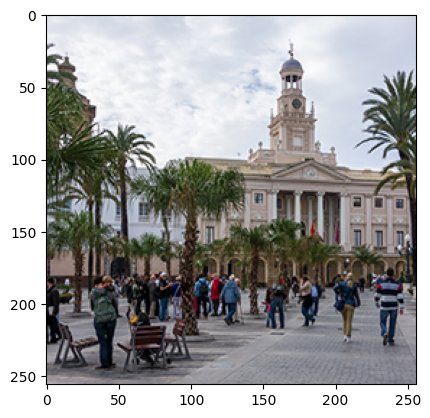

In [176]:
import matplotlib.image as mpimg

# Read an image file
img = mpimg.imread("./src/Resized_Plaza_san_juan.jpg")
img = img.reshape((1, 256, 256, 3))
plt.imshow(img[0])

In [178]:
text ="""Me han dicho que el amarillo
Está maldito
Para los artistas
Y ese color, sin embargo,
Es gloria bendita
Para los cadistas"""
text =ascii_encode(text)
text

array([[ 77., 101.,  32., 104.,  97., 110.,  32., 100., 105.,  99., 104.,
        111.,  32., 113., 117., 101.,  32., 101., 108.,  32.,  97., 109.,
         97., 114., 105., 108., 108., 111.,  10.,  69., 115., 116., 225.,
         32., 109.,  97., 108., 100., 105., 116., 111.,  10.,  80.,  97.,
        114.,  97.,  32., 108., 111., 115.,  32.,  97., 114., 116., 105.,
        115., 116.,  97., 115.,  10.,  89.,  32., 101., 115., 101.,  32.,
         99., 111., 108., 111., 114.,  44.,  32., 115., 105., 110.,  32.,
        101., 109.,  98.,  97., 114., 103., 111.,  44.,  10.,  69., 115.,
         32., 103., 108., 111., 114., 105.,  97.,  32.,  98., 101., 110.,
        100., 105., 116.,  97.,  10.,  80.,  97., 114.,  97.,  32., 108.,
        111., 115.,  32.,  99.,  97., 100., 105., 115., 116.,  97., 115.,
         32.,  32.,  32.,  32.,  32.,  32.,  32.]])

In [24]:
prediction= model.predict([img/255., text])

NameError: name 'text' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


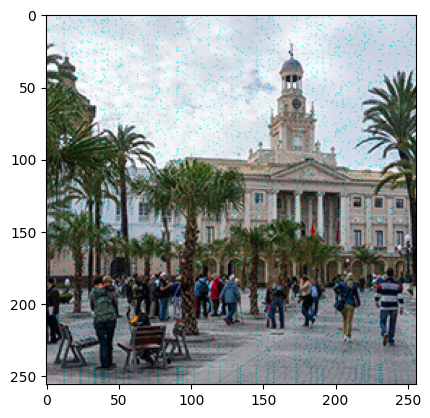

In [180]:
plt.imshow(prediction[0][0])

In [181]:
decode_text(prediction[1][0])

[ 77 101  32 104  97 110  32 100 105  99 104 111  32 113 117 101  32 101
 108  32  97 109  97 114 105 108 108 111  10  69 115 116 225  32 109  97
 108 100 105 116 111  10  80  97 114  97  32 108 111 115  32  97 114 116
 105 115 116  97 115  10  89  32 101 115 101  32  99 111 108 111 114  44
  32 115 105 110  32 101 109  98  97 114 103 111  44  10  69 115  32 103
 108 111 114 105  97  32  98 101 110 100 105 116  97  10  80  97 114  97
  32 108 111 115  32  99  97 100 105 115 116  97 115  32  32  32  32  32
  32  32]


'Me han dicho que el amarillo\nEstá maldito\nPara los artistas\nY ese color, sin embargo,\nEs gloria bendita\nPara los cadistas       '

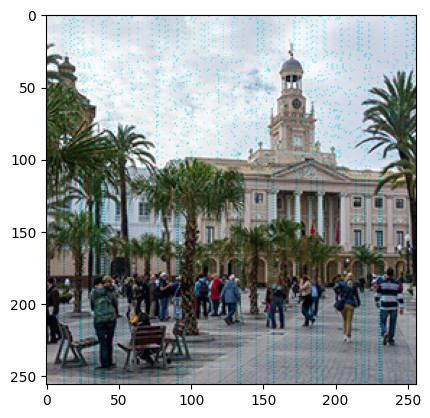

In [31]:
import matplotlib.image as mpimg

# Read an image file
img = mpimg.imread("./src/plaza-dios-prueba.jpg")
img = img[:, :, :3]
img = img.reshape((1, 256, 256, 3))
plt.imshow(img[0])

In [32]:
text = model.decoder.predict(img)

1/1 [==============================] - 0s 42ms/step


In [33]:
decode_text(text[0])

[104 111  97 108  97 108  97 108  97 108  97 108  97 115 100 108 109 115
 115 105 111 102 100 102  98 117 100 105 118  98 100  99 120  57 118 111
 110 120 111 117 105 100 117  98 118  32  99 111 109 111  32 101 115 116
  97 115  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  32  32]


'hoalalalalalasdlmssiofdfbudivbdcx9vonxouidubv como estas                                                                        '